# Machine Problem 3: NumPy CNN

### Import Libraries

In [1]:
import numpy as np
import os
import time
from scipy import signal
from imageio import imread
from random import shuffle
from matplotlib import pyplot as plt

%matplotlib inline

### Preprocessing Functions

In [2]:
# load_images
    # Read in images and makes a list for each set in the form: [images, labels]
    # images: np array with dims [N x img_height x img width x num_channels]
    # labels: np array with dims [N x 1]. elephant = 0, lionfish = 1
    #
    # Returns:  train_set: The list [train_images, train_labels]
    #           val_set: The list [val_images, val_labels] 

def load_images():
    
    sets = ['train', 'val']
    
    data_sets = []
    for dset in sets:
        img_path = './bin_dataset/' + dset + '/ele'
        ele_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        img_path = './bin_dataset/' + dset + '/lio'
        lio_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        set_images = np.stack(ele_list + lio_list)
        N = set_images.shape[0]
        labels = np.ones((N,1))
        labels[0:int(N/2)] = 0
        data_sets.append([set_images, labels])

    train_set, val_set = data_sets

    print("Loaded", len(train_set[0]), "training images")
    print("Loaded", len(val_set[0]), "validation images")
    
    return train_set, val_set


# batchify
    # Inputs:    train_set: List containing images and labels
    #            batch size: The desired size of each batch
    #
    # Returns:   image_batches: A list of shuffled training image batches, each with size batch_size
    #            label_batches: A list of shuffled training label batches, each with size batch_size 

def batchify(train_set, batch_size):
    
    # YOUR CODE HERE
    # initialized two lists
    image_batches = []
    label_batches = []
    
    shuffle_index = np.arange(len(train_set[0]))
    shuffle(shuffle_index)
    
    image_chunk = [None] * batch_size
    label_chunk = [None] * batch_size
    for c in range(0, len(shuffle_index), batch_size):
        for i in range(batch_size):
            image_chunk[i] = train_set[0][shuffle_index[c+i]]
            label_chunk[i] = train_set[1][shuffle_index[c+i]]
        image_batches.append(np.array(image_chunk))
        label_batches.append(np.array(label_chunk))

    return image_batches, label_batches


### Network Functions

In [3]:
def data_transform(data_set):
    data, label = data_set
    data = data.astype(float)
    data /= 256.0
    return [data, label]

#### Activation Functions

In [4]:
# relu
    # Inputs:   x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:  out: Multi-dimensional array with same size of x 

def relu(x):
    
    # YOUR CODE HERE
    out = np.maximum(x, 0)
    return out


# sigmoid
    # Inputs:    x: Multi-dimensional array with size N along the first axis
    # 
    # Returns:   out: Multi-dimensional array with same size of x 

def sigmoid(x):
    
    # YOUR CODE HERE
    out = 1.0/(1 + np.exp(-x))
    return out

def d_sigmoid(x):
    out = sigmoid(x) * (1-sigmoid(x))
    return out

# unit_step
    # Inputs:    x: Multi-dimensional array with size N along the first axis 
    # 
    # Returns:   out: Multi-dimensional array with same size of x 

def unit_step(x):
    
    # YOUR CODE HERE
    out = np.heaviside(x, 1)
    return out 

#### Layer Functions

In [5]:
# helper function to calculate 2D convlolution
# input X 2D array with size NxN
# input F 2D array with size fxf
# output out 2D array with size N+f-1 x N+f-1
def convolution2D(X, F):
    N, _ = X.shape
    f, _ = F.shape
    S = N-f+1
    out = np.zeros((S, S))
    for i in range(S):
        for j in range(S):
            out[i, j] = np.sum(F[::-1, ::-1]*X[i:i+f, j:j+f])
    return out
    
# convolve2D
    # Inputs:    X: [N x height x width x num_channels]
    #            filters: [num_filters x filter_height x filter_width x num_input_channels]
    # 
    # Returns:   Xc: output array by convoling X and filters. [N x output_height x output_width x num_filters]

def convolve2D(X0, filters):
   
    N, X0_len, _, num_ch = X0.shape
    num_out_ch, filter_len, _, _ = filters.shape
    F0_side = X0_len - filter_len + 1
    
    F0 = np.zeros((N, F0_side, F0_side, num_out_ch))
    
    for n in range(N):
        for o_ch in range(num_out_ch):
            for ch in range(num_ch):
                # YOUR CODE HERE
                # F0[n, :, :, o_ch] += convolution2D(X0[n, :, :, ch], filters[o_ch, :, :, ch])
                F0[n,0:,0:,o_ch] += signal.convolve2d(X0[n,0:,0:,ch], filters[o_ch, 0:, 0:, ch], mode = "valid")
    return F0


# maxPool
    # Inputs:    R0: [N x height x width x num_channels]
    #            mp_len: size of max pool window, also the stride for this MP
    # 
    # Returns:   p_out: output of pooling R0. [N x output_height x output_width x num_channels]
    #            R0_mask: A binary mask with the same size as R0. Indicates which index was chosen to be the max
    #            for each max pool window. This will be used for backpropagation.

def maxPool(R0, mp_len):

    N, R0_len, _, num_ch = R0.shape
    p_out_len = int((R0_len-mp_len)/mp_len + 1)

    R0_mask = np.zeros(R0.shape)
    p_out = np.zeros((N, p_out_len, p_out_len, num_ch))
    
    for n in range(N):
        for ch in range(num_ch):
            for row in range(p_out_len): 
                for col in range(p_out_len):
                    # YOUR CODE HERE
                    r = row*mp_len
                    c = col*mp_len
                    p_out[n, row, col, ch] = np.amax(R0[n, r:min(r+mp_len, R0_len), c:min(c+mp_len, R0_len), ch])
                    max_idx = np.argmax(R0[n, r:min(r+mp_len, R0_len), c:min(c+mp_len, R0_len), ch])
                    row_idx = max_idx // mp_len + r
                    col_idx = max_idx % mp_len + c
                    R0_mask[n][row_idx][col_idx][ch] = 1
    return p_out, R0_mask

def flatten(Y):
    # flatten function takes a 4D array and output a 2D array
    # input Y: N x N1 x N2 x K
    # output out: N x (N1*N2*K)
    N, N1, N2, K = Y.shape
    out = Y.reshape((N, N1*N2*K))
    return out

# fc
    # Inputs:    X: [N x num_input_features]
    #            W: [num_input_features x num_fc_nodes]
    # 
    # Returns:   out: Linear combination of X and W. [N x num_fc_nodes]

def fc(X, W):
    
    # YOUR CODE HERE
    out = X @ W
    return out

#### CNN Functions

In [6]:
# cnn_fwd
    # Inputs:    X0: batch of images. [N x img_height x img_width x num_channels]
    #            W0, W1, W2: Parameters of the CNN
    #            mp_len: the length of one side of the max pool window
    # 
    # Returns:   sig: vector containing the output for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations that will be
    #            used in backpropagation
    
def cnn_fwd(X0, W0, W1, W2, mp_len):
    
    # F0 
    # YOUR CODE HERE
    F0 = convolve2D(X0, W0)
    
    # X1p 
    # YOUR CODE HERE
    R0 = relu(F0)
    X1p, R0_mask = maxPool(R0, mp_len)
    
    # X1 (flatten)
    # YOUR CODE HERE
    X1 = flatten(X1p)
    
    # FC Layers
    # YOUR CODE HERE
    F1 = fc(X1, W1)
    
    # Output
    # YOUR CODE HERE
    X2 = relu(F1)
    F2 = fc(X2, W2)
    sig = sigmoid(F2)
    
    # Save outputs of functions for backward pass
    cache = {
        "F0":F0,
        "R0":R0,
        "X1p":X1p,
        "R0m":R0_mask,
        "X1":X1,
        "F1":F1,
        "X2":X2,
        "F2":F2,
        "sig":sig
    }
    
    return sig, cache


# loss
    # Inputs:    sig: vector containing the CNN output for each sample. [N x 1]
    #            Y: vector containing the ground truth label for each sample. [N x 1]
    # 
    # Returns:   L: Loss/error criterion for the model. 

def loss(sig, Y):
    
    # YOUR CODE HERE
    # cross entropy
    L = 0.0
    N, _ = Y.shape
    for i in range(N):
        L -= Y[i]*np.log(sig[i]) + (1-Y[i])*np.log(1-sig[i])
    L /= N
    return L


### Backprop Functions

In [14]:
# convolve2DBwd
    # Inputs:    X0: batch of images. [N x height x width x num_channels]
    #            dL_dF0: Gradient at the output of the conv layer. 
    # 
    # Returns:   dL_dW0. gradient of loss L wrt W0. Same size as W0

def convolve2DBwd(X0, dL_dF0):
    
    N, X0_len, _, num_ch = X0.shape
    _, dL_dF0_len, _, num_out_ch  = dL_dF0.shape
    filter_len = X0_len - dL_dF0_len + 1
    
    dL_dW0 = np.zeros((num_out_ch, filter_len, filter_len, num_ch))
    
    for n in range(N):
        for o_ch in range(num_out_ch):
            for ch in range(num_ch):
                # YOUR CODE HERE
                dL_dW0[o_ch,:,:,ch] += signal.correlate2d(X0[n,:,:,ch], dL_dF0[n,:,:,o_ch], mode="valid") 
                # dL_dW0[o_ch,:,:,ch] += signal.convolve2d(X0[n,:,:,ch], dL_dF0[n,:,:,o_ch], mode="valid") 
    return dL_dW0


# maxPoolBwd
    # Inputs:    dL_dX1p: Gradient at the output of the MaxPool layer
    #            R0_mask: A binary mask with the same size as R0. Defined in maxPool
    #            mp_len: the length of one side of the max pool window
    # 
    # Returns:   dL_dR0: Gradient at the output of ReLu
    
def maxPoolBwd(dL_dX1p, R0_mask,  mp_len):
    
    N, H, W, C = R0_mask.shape
    N, dH, dW, C = dL_dX1p.shape
    
    dL_dR0 = np.zeros(R0_mask.shape)
    
    for n in range(N):
        for ch in range(C):
            for row in range(dH):
                for col in range(dW):
                    # YOUR CODE HERE
                    dL_dR0[n,row*mp_len:(row+1)*mp_len, col*mp_len:(col+1)*mp_len,ch] = dL_dX1p[n,row,col,ch]*R0_mask[n,row*mp_len:(row+1)*mp_len, col*mp_len:(col+1)*mp_len,ch]
    return dL_dR0

# dL_dF2
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dF2: Gradient of the Loss wrt F2
def dL_dF2(Y, cache):
    sig = cache["sig"]
    N, _ = Y.shape
    dL_dF2 = (sig - Y) / N
    return dL_dF2
    
# dL_dW2
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW2: Gradient of the Loss wrt W2
    
def dL_dW2(cache, dL_dF2):
   
    # YOUR CODE HERE
    X2 = cache["X2"]
    dL_dW2 = X2.T @ dL_dF2
    return dL_dW2

# dL_dX2
    # Inputs:    Y: vector containing the ground truth label for each sample. [N x 1]
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dX2: Gradient of the Loss wrt X2
    
def dL_dX2(dL_dF2, W2):
    
    # YOUR CODE HERE
    dL_dX2 = dL_dF2 @ W2.T
    return dL_dX2

# dL_dF1
    # Inputs:    dL_dX2
    # 
    # Returns:   dL_dF1: Gradient of the Loss wrt F1
def dL_dF1(cache, dL_dX2):
    F1 = cache["F1"]
    dL_dF1 = dL_dX2 * unit_step(F1)
    return dL_dF1


# dL_dW1
    # Inputs:    dL_dF1 
    # 
    # Returns:   dL_dW1: Gradient of the Loss wrt W1
    
def dL_dW1(cache, dL_dF1):
    X1 = cache["X1"]
    dL_dW1 = X1.T @ dL_dF1
    return dL_dW1

# dL_dX1
    # Inputs:    dL_dF1
    #            W1
    # 
    # Returns:   dL_dX1: Gradient of the Loss wrt X1
    
def dL_dX1(dL_dF1, W1):
    
    # YOUR CODE HERE
    dL_dX1 = dL_dF1 @ W1.T
    return dL_dX1

def dL_dR0(dL_dX1p, cache):

    R0m = cache['R0m']
    dL_dR0 = R0m
    for n in range(R0m.shape[0]):
        for f in range(R0m.shape[-1]):
            for r in range(R0m.shape[1]):
                for c in range(R0m.shape[2]):
                    dL_dR0[n][r][c][f] = R0m[n][r][c][f] * dL_dX1p[n][r//12][c//12][f]
    
    return dL_dR0


# dL_dW0
    # Inputs:    X0: batch of images. [N x height x width x num_channels]
    #            Y: vector containing the ground truth label for each sample. [N x 1]
    #            W1: Weight matrix for the first FC layer
    #            W2: Weight matrix for the second FC layer
    #            mp_len: the length of one side of the max pool window
    #            cache: a dict containing the relevant output layer calculations 
    # 
    # Returns:   dL_dW0: Gradient of the Loss wrt W0

# def dL_dW0(X0, Y, W1, W2, mp_len, cache):
def cnn_bwd(X0, Y, W1, W2, mp_len, cache):  
    N, X1p_len, _, no_out_ch  = cache['X1p'].shape
    F2 = cache['F2']
    F1 = cache['F1']
    R0m = cache['R0m']
    F0 = cache['F0']
    
    #dL_dF2
    # YOUR CODE HERE
    dF2 = dL_dF2(Y, cache)
    dW2 = dL_dW2(cache, dF2)
    dX2 = dL_dX2(dF2, W2)
    
    #dL_dF1
    # YOUR CODE HERE
    dF1 = dL_dF1(cache, dX2)
    
    # dL_dW1
    dW1 = dL_dW1(cache, dF1)
    
    #dL_dX1
    # YOUR CODE HERE
    dX1 = dL_dX1(dF1, W1)
    
    # dL_dX1p (unflatten)
    # YOUR CODE HERE
    dX1p = dX1.reshape(cache["X1p"].shape)
    
    # dL_dR0 (unpool)
    # YOUR CODE HERE
    dR0 = maxPoolBwd(dX1p, R0m,  mp_len)
    # dR0_1 = dL_dR0(dX1p, cache)

    # dL_dF0 (relu_bwd)
    # YOUR CODE HERE
    dF0 = dR0 * unit_step(F0)
    
    # dL_dW0
    # YOUR CODE HERE
    dW0 = convolve2DBwd(X0, dF0)
    
    return dW0, dW1, dW2
    

### Update the training variables

In [15]:
def update(W0, W1, W2, dL_dW0, dL_dW1, dL_dW2, lr):
    # update the training parameters bt gradient calculated
    new_W0 = W0 - lr * dL_dW0
    new_W1 = W1 - lr * dL_dW1
    new_W2 = W2 - lr * dL_dW2
    return new_W0, new_W1, new_W2

### Training

#### Load Images

In [9]:
# Load images and scale them
# YOUR CODE HERE
train_set, val_set = load_images()
train_set = data_transform(train_set)
val_set = data_transform(val_set)

Loaded 2000 training images
Loaded 800 validation images


#### Config

In [58]:
# Hyperparameters
epochs = 20
lr = 0.1
image_size = 100
batch_size = 16
filter_len = 5
num_out_ch = 3
mp_len = 12
fc_nodes = 2
W1_len = int((image_size-filter_len+1)/mp_len)

# Declare weights
# YOUR CODE HERE
# W0 = np.random.normal(0, 0.05, weights['W0'].shape)
# W1 = np.random.normal(0, 0.05, weights['W1'].shape)
# W2 = np.random.normal(0, 0.05, weights['W2'].shape)
# print(W0.shape)
# print(W1.shape)
# print(W2.shape)
W0 = np.random.normal(0, 0.05, (num_out_ch, filter_len, filter_len, 3))
W1 = np.random.normal(0, 0.05, (W1_len*W1_len*num_out_ch, fc_nodes))
W2 = np.random.normal(0, 0.05, (fc_nodes, 1))

In [59]:
accuracy = []
for i in range(epochs):
    
    # make set of batches
    # YOUR CODE HERE
    image_batches, label_batches = batchify(train_set, batch_size)
    num_batches = len(image_batches)
    
    # record the time for the execution
    start_time = time.time()
    for b_idx in range(num_batches):
        X = image_batches[b_idx]
        Y = label_batches[b_idx]
        
        # Forward pass
        # YOUR CODE HERE
        sig, cache = cnn_fwd(X, W0, W1, W2, mp_len)
        
        # Calculate gradients
        # YOUR CODE HERE
        dW0, dW1, dW2 = cnn_bwd(X, Y, W1, W2, mp_len, cache)
        
        # Update gradients
        # YOUR CODE HERE
        W0, W1, W2 = update(W0, W1, W2, dW0, dW1, dW2, lr)
        
    # calcuate the loss and accuracy in each epoch
    train_acc = len(np.where(np.round(sig) == Y)[0])/len(Y)
    accuracy.append(train_acc)
    print("After epoch", i)
    print("train_loss:", loss(sig, Y), "train_acc:", train_acc)
    print("---total cost for this epoch is %s seconds ---" % (time.time() - start_time))

After epoch 0
train_loss: [0.4434027] train_acc: 0.75
---total cost for this epoch is 33.34269905090332 seconds ---
After epoch 1
train_loss: [0.67510712] train_acc: 0.25
---total cost for this epoch is 31.783432245254517 seconds ---
After epoch 2
train_loss: [0.44529879] train_acc: 0.9375
---total cost for this epoch is 32.52655482292175 seconds ---
After epoch 3
train_loss: [0.68093458] train_acc: 0.75
---total cost for this epoch is 33.60148000717163 seconds ---
After epoch 4
train_loss: [0.62043578] train_acc: 0.625
---total cost for this epoch is 31.831631183624268 seconds ---
After epoch 5
train_loss: [0.37551744] train_acc: 0.8125
---total cost for this epoch is 30.184813022613525 seconds ---
After epoch 6
train_loss: [0.46354937] train_acc: 0.6875
---total cost for this epoch is 31.852598190307617 seconds ---
After epoch 7
train_loss: [0.58265797] train_acc: 0.6875
---total cost for this epoch is 32.21555304527283 seconds ---
After epoch 8
train_loss: [0.39281466] train_acc: 0.

### Plot the Accuracy vs Epoches

Text(0.5,1,'Accuracy vs Epoches')

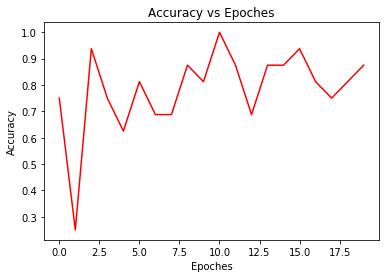

In [60]:
index = np.arange(epochs)
plt.plot(index, accuracy, 'r-')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoches")

### Test on Validation Data

In [61]:
start_time = time.time()
sig, cache = cnn_fwd(val_set[0], W0, W1, W2, mp_len)
test_acc = len(np.where(np.round(sig) == val_set[1])[0])/len(val_set[1])
print("test_loss:", loss(sig, val_set[1]), "test_acc:", test_acc)
print("---total cost is %s seconds ---" % (time.time() - start_time))

test_loss: [0.51930529] test_acc: 0.83125
---total cost is 7.474307060241699 seconds ---


### Apply $W_0$ to the validation and see which feature are learned

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


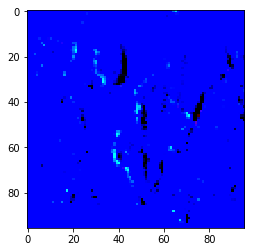

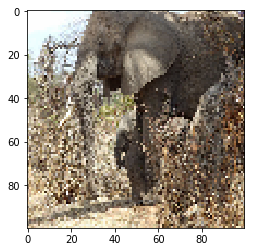

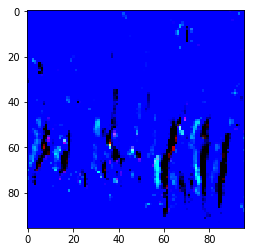

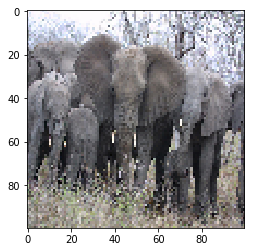

In [62]:
F0 = cache["F0"]
plt.imshow(F0[0])
plt.figure()
plt.imshow(val_set[0][0])
plt.figure()
plt.imshow(F0[1])
plt.figure()
plt.imshow(val_set[0][1])

### Confusion Matrix for Validation Data

In [77]:
def confusion(sig, Y):
    # sig is the prediction and Y is the ground label
    N, _ = Y.shape
    predict = np.round(sig)
    c = np.zeros((2, 2))
    for i in range(N):
        if predict[i] == 0 and Y[i] == 0:
            c[0, 0] += 1
        elif predict[i] == 1 and Y[i] == 0:
            c[0, 1] += 1
        elif predict[i] == 0 and Y[i] == 1:
            c[1, 0] += 1
        elif predict[i] == 1 and Y[i] == 1:
            c[1, 1] += 1
    print(c)
    c[0, :] = c[0, :]/np.sum(c[0, :])
    c[1, :] = c[1, :]/np.sum(c[1, :])
    return c

In [78]:
confusion_matrix = confusion(sig, val_set[1])
print(confusion_matrix)

[[368.  32.]
 [103. 297.]]
[[0.92   0.08  ]
 [0.2575 0.7425]]


### Test Correctness of Forward and Backward Pass

#### Forward

In [53]:
weights = np.load('weights.npz')
W0 = weights['W0']
W1 = weights['W1']
W2 = weights['W2']

# record the time for the execution
start_time = time.time()
sig, cache = cnn_fwd(val_set[0], W0, W1, W2, mp_len)
train_acc = len(np.where(np.round(sig) == val_set[1])[0])/len(val_set[1])

print("train_loss:", loss(sig, val_set[1]), "train_acc:", train_acc)
print("---total cost is %s seconds ---" % (time.time() - start_time))

test_loss: [0.23266417] test_acc: 0.9175
---total cost is 9.743844032287598 seconds ---


#### Backward

In [16]:
# Make backprop testing batch
X_bp = np.vstack([train_set[0][0:8,:,:,:], train_set[0][-9:-1,:,:,:]])
Y_bp = np.vstack([train_set[1][0:8], train_set[1][-9:-1]])

# Initialize weights to all ones
# YOUR CODE HERE
W0 = np.ones_like(weights['W0'])
W1 = np.ones_like(weights['W1'])
W2 = np.ones_like(weights['W2'])

# Update weights once
# YOUR CODE HERE
sig, cache = cnn_fwd(X_bp, W0, W1, W2, mp_len)
dW0, dW1, dW2 = cnn_bwd(X_bp, Y_bp, W1, W2, mp_len, cache)
W0, W1, W2 = update(W0, W1, W2, dW0, dW1, dW2, lr)

print("W2 value:", np.sum(W2))
print("W1 value:", np.sum(W1))
print("W0 value:", np.sum(W0))

W2 value: -881.56533203125
W1 value: -499.5653320312501
W0 value: -658.5653320312499
